In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# GPU-Beschleunigung importieren (optional)
try:
    import cudf
    import cupy as cp
    USE_GPU = True
    print("GPU-Beschleunigung ist aktiviert (RAPIDS-Bibliotheken geladen)")
except ImportError:
    USE_GPU = False
    print("GPU-Beschleunigung ist nicht verfügbar, verwende CPU-Version")

GPU-Beschleunigung ist nicht verfügbar, verwende CPU-Version


In [4]:
# Load the merged dataset
if USE_GPU:
    df = cudf.read_csv('data/german_courts.csv')
    print("Datensatz mit GPU-Beschleunigung geladen")
else:
    df = pd.read_csv('data/german_courts.csv')
    print("Datensatz mit CPU geladen")

Datensatz mit CPU geladen


In [5]:
# Datenstruktur anzeigen
print(df.head())
print(df.columns)

          id        date                                            summary  \
0   bag_1-17  18.01.2017  18.01.2017\n1/17 - Betriebsratstätigkeit - Arb...   
1   bag_1-19  22.01.2019  22.01.2019\n1/19 - Urlaubsabgeltung bei Tod de...   
2  bag_10-19  20.02.2019  20.02.2019\n10/19 - Kündigung des Chefarztes e...   
3  bag_11-18  22.02.2018  22.02.2018\n11/18 - Annahmeverzugsvergütung al...   
4  bag_11-20  27.02.2020  27.02.2020\n11/20 - Kündigungen des Cockpit-Pe...   

                                           judgement           subset_name  \
0  Tenor\n\n\n\n\nAuf die Revision der Beklagten ...  Bundesarbeitsgericht   
1  Tenor\n\n\n\n\n1. Die Revision der Beklagten g...  Bundesarbeitsgericht   
2  Tenor\n\n\n\n\nDie Revision der Beklagten gege...  Bundesarbeitsgericht   
3  Tenor\n\n\n\n\n1. Die Revision des Beklagten g...  Bundesarbeitsgericht   
4  Tenor\n\n\n\n\nAuf die Revision des Klägers wi...  Bundesarbeitsgericht   

  split_name  
0      train  
1      train  
2      trai

## Exploration

In [6]:
# Länge der Zusammenfassung und des Urteils für spätere Bereinigung berechnen
df['summary_length'] = df['summary'].str.len()
df['judgement_length'] = df['judgement'].str.len()
print(df[['summary_length', 'judgement_length']].describe())

       summary_length  judgement_length
count     6592.000000       6592.000000
mean      4681.862712      34780.566444
std       3250.552745      35041.156251
min        330.000000        959.000000
25%       2726.750000      16608.000000
50%       3732.000000      25987.000000
75%       5494.500000      40526.250000
max      41126.000000     746154.000000


In [7]:
# Auf Duplikate prüfen
print(f"Anzahl der doppelten Zeilen: {df.duplicated().sum()}")
print(f"Anzahl der doppelten IDs: {df['id'].duplicated().sum()}")

Anzahl der doppelten Zeilen: 0
Anzahl der doppelten IDs: 0



Verteilung der Fälle nach Jahr:


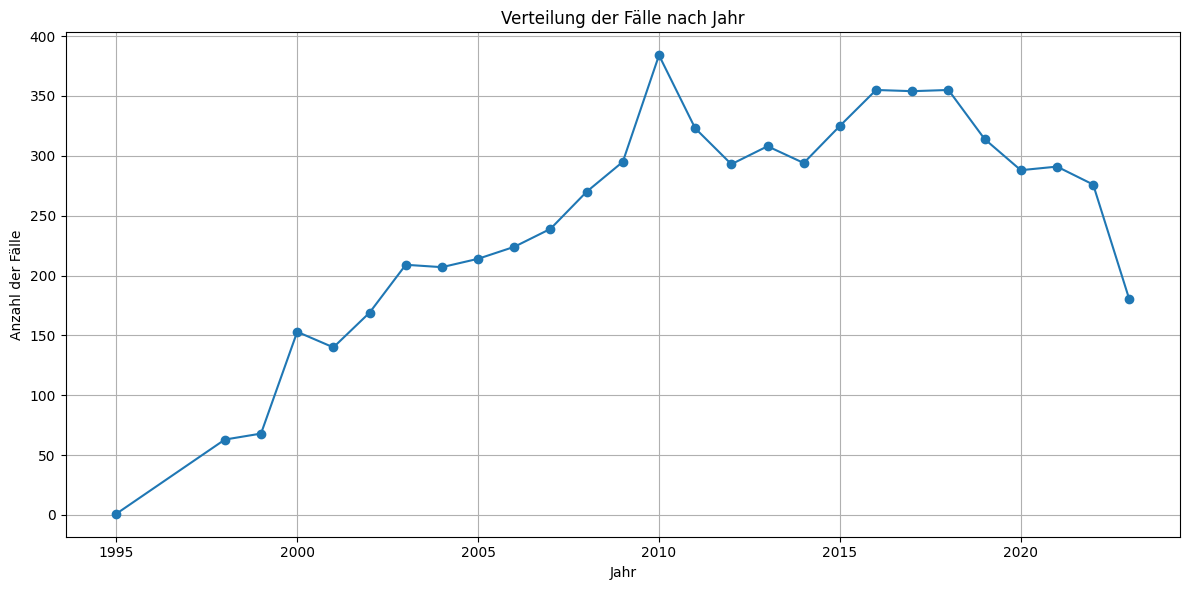

In [8]:
# Verteilung nach Jahren ansehen
df['year'] = df['date'].str.extract(r'(\d{4})').astype(int)
year_counts = df['year'].value_counts().sort_index()
print("\nVerteilung der Fälle nach Jahr:")
# print(year_counts) 
plt.figure(figsize=(12, 6))
year_counts.plot(kind='line', marker='o')
plt.title('Verteilung der Fälle nach Jahr')
plt.xlabel('Jahr')
plt.ylabel('Anzahl der Fälle')
plt.grid(True)
plt.tight_layout()
plt.show()


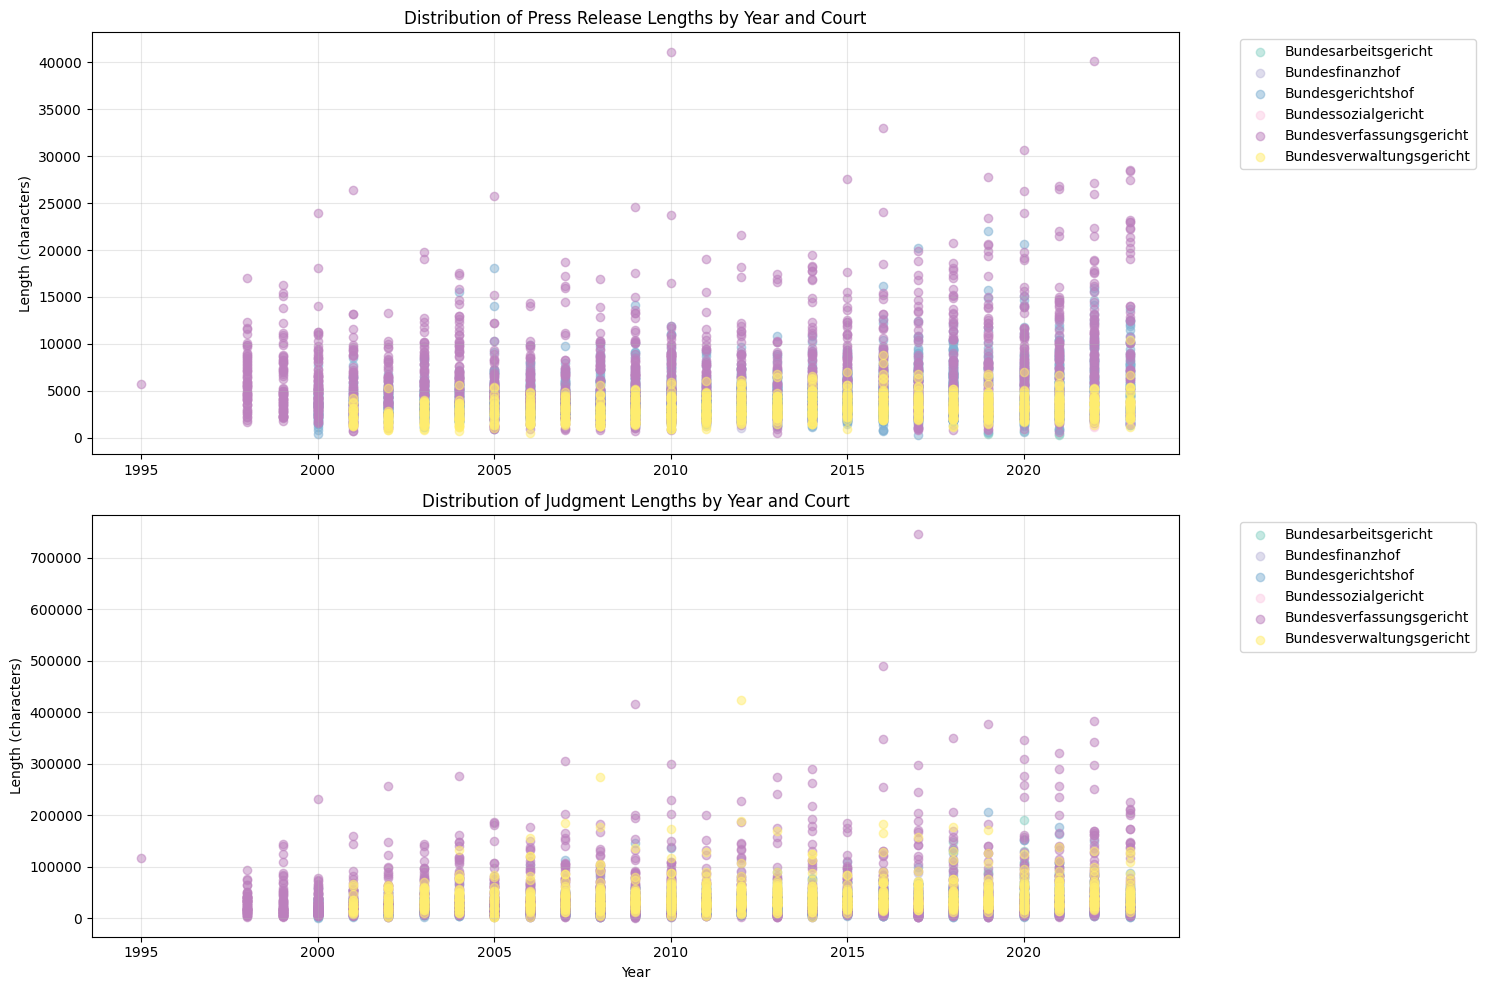

In [9]:
# Create scatter plots for summary and judgement lengths
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))

# Get unique courts for color mapping
courts = df['subset_name'].unique()
colors = plt.cm.Set3(np.linspace(0, 1, len(courts)))

# Plot summary lengths
for court, color in zip(courts, colors):
  mask = df['subset_name'] == court
  ax1.scatter(df[mask]['year'], df[mask]['summary_length'], 
        label=court, alpha=0.5, color=color)

ax1.set_title('Distribution of Press Release Lengths by Year and Court')
ax1.set_ylabel('Length (characters)')
ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax1.grid(True, alpha=0.3)

# Plot judgement lengths
for court, color in zip(courts, colors):
  mask = df['subset_name'] == court
  ax2.scatter(df[mask]['year'], df[mask]['judgement_length'], 
        label=court, alpha=0.5, color=color)

ax2.set_title('Distribution of Judgment Lengths by Year and Court')
ax2.set_xlabel('Year')
ax2.set_ylabel('Length (characters)')
ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [10]:
# Prüfung auf Urteile ohne Pressemitteilungen und umgekehrt
print("\nPrüfung auf fehlende Inhalte:")
# Leere oder fehlende Zusammenfassungen finden
missing_summaries = df[df['summary'].isna() | (
    df['summary'].str.strip() == '')]
print(f"Anzahl der Einträge ohne Pressemitteilung: {len(missing_summaries)}")
if len(missing_summaries) > 0:
    print("Beispiele für fehlende Pressemitteilungen:")
    print(missing_summaries[['id', 'date', 'judgement']].head(3))

# Leere oder fehlende Urteile finden
missing_judgements = df[df['judgement'].isna() | (
    df['judgement'].str.strip() == '')]
print(f"Anzahl der Einträge ohne Urteil: {len(missing_judgements)}")
if len(missing_judgements) > 0:
    print("Beispiele für fehlende Urteile:")
    print(missing_judgements[['id', 'date', 'summary']].head(3))


Prüfung auf fehlende Inhalte:
Anzahl der Einträge ohne Pressemitteilung: 0
Anzahl der Einträge ohne Urteil: 0


In [11]:
# Kurze Pressemitteilungen mit langen Urteilen finden (möglicherweise unvollständige Zusammenfassungen)
summary_judgement_ratio = df['summary_length'] / df['judgement_length']
unusual_ratio = df[(summary_judgement_ratio < 0.05) &
                   (df['judgement_length'] > 1000)]
print(
    f"Anzahl der Einträge mit sehr kurzer Pressemitteilung im Vergleich zum Urteil: {len(unusual_ratio)}")
if len(unusual_ratio) > 0:
    print("Beispiele für ungewöhnliche Verhältnisse:")
    print(unusual_ratio[['id', 'summary_length', 'judgement_length']].head(3))

Anzahl der Einträge mit sehr kurzer Pressemitteilung im Vergleich zum Urteil: 281
Beispiele für ungewöhnliche Verhältnisse:
           id  summary_length  judgement_length
2   bag_10-19            3843             92410
4   bag_11-20            3890            190350
14  bag_15-20            3157            131152


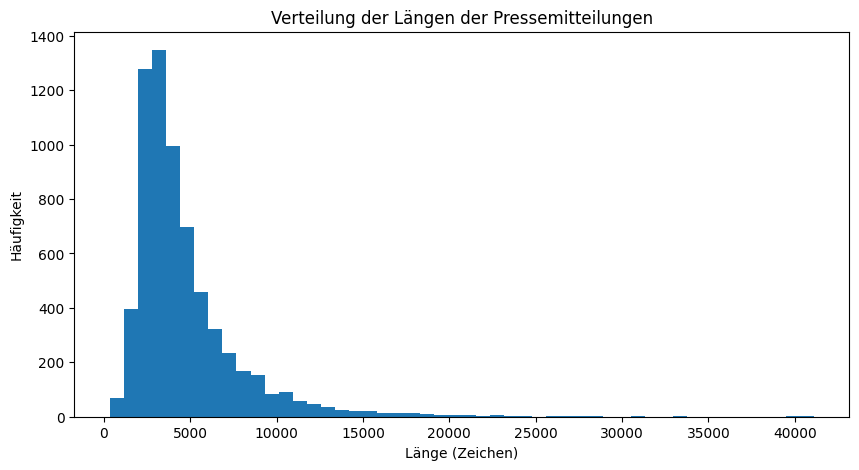


Sehr kurze Zusammenfassungen (möglicherweise problematisch):
            id                                            summary
19   bag_17-19  09.04.2019\n17/19 - Informationsanspruch des B...
28   bag_21-18  26.04.2018\n21/18 - Entgeltumwandlung - Kündig...
66   bag_38-19  19.11.2019\n38/19 - Mindestpersonalbesetzung a...
116   bag_9-20  25.02.2020\n9/20 - Keine Entscheidung über Mit...
125  bag_17-21  01.07.2021\n17/21 - Mitteilung zum Verfahren -...

Sehr lange Zusammenfassungen (möglicherweise problematisch):
                id                                            summary
974   bgh_007-2010  Nachträgliche Sicherungsverwahrung gegen Sexua...
1048  bgh_018-2010  Bundesgerichtshof zu Vertragsbedingungen eines...
1367  bgh_067-2016  Bundesgerichtshof entscheidet über die Grenzen...
1551  bgh_095-2013  Bundesgerichtshofs entscheidet erneut im Verfa...
1699  bgh_112-2014  Zum Ausschluss von Ansprüchen wegen Spätfolgen...


In [12]:
# Muster in Zusammenfassungen suchen, die auf nicht-urteilsbezogene Einträge hinweisen könnten

# Verteilung der Längen der Zusammenfassungen anzeigen
plt.figure(figsize=(10, 5))
plt.hist(df['summary_length'], bins=50)
plt.title('Verteilung der Längen der Pressemitteilungen')
plt.xlabel('Länge (Zeichen)')
plt.ylabel('Häufigkeit')
plt.show()

# Einige sehr kurze und sehr lange Zusammenfassungen als Beispiele anzeigen
print("\nSehr kurze Zusammenfassungen (möglicherweise problematisch):")
short_summaries = df[df['summary_length'] < df['summary_length'].quantile(0.05)]
print(short_summaries[['id', 'summary']].head())

print("\nSehr lange Zusammenfassungen (möglicherweise problematisch):")
long_summaries = df[df['summary_length'] > df['summary_length'].quantile(0.95)]
print(long_summaries[['id', 'summary']].head())